# Boundary value problem

We will now return to solve the boundary value problem

$$
\frac{d^2u}{dx^2} = -\frac{\pi^2}{4} \left(u + 1\right)
$$

Here, we will have Dirichlet boundary conditions, as before, such that $u(0)=0$ and $u(1)=1$.

## Analytic solution

Recall from previous assignments that the analytic solution is

$$
u(x) = \cos\left(\frac{\pi}{2}x\right) + 2\sin\left(\frac{\pi}{2}x\right) -1
$$

## Shooting method


The first solution we will investigate here is a "shooting" method. We use a stepping ODE solver (in our case, RK4) to "shoot" the differential equation from one boundary to the other. We will then use a root-finding algorithm to find the value of $u(x=1)$. The algorithm will shoot above and below the root, and converge to the right answer at the boundaries.

Note, however, that the internal values will not necessarily be so accurately represented. 

## Relaxation method


The next solution we will investigate here is a "relaxation" method. This is going to be very similar to PDE solvers later in the semester. We will start with an initial guess, and use Jacobi's algorithm to iterate until the difference between the computed second derivative stabilizes to a constant value. 

In this case, the internal values ARE accurately represented. 

In [1]:
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt
from bvp import *

### Set up functions

In [2]:
def simpleBVPFunc(u):
    return -np.pi**2 * (u+1)*0.25

def simpleBVP(x, state):
    u = state[0] ; uprime = state[1]
    du_dx = uprime
    duprime_dx = simpleBVPFunc(u)
    return [du_dx, duprime_dx]

def analytic(x):
    return -1. + np.cos(np.pi*0.5*x)+2.*np.sin(np.pi*0.5*x)

### Evaluate BVP

In [3]:
xbounds = np.array([0.,1.])
ubounds = np.array([0.,1.])
uprime = 3
bvpshoot = BVPShoot( simpleBVP, xbounds, ubounds, uprime )
%timeit -r 10 -n 10 bvpshoot.solve() # line timeit r: number of runs n: number of loops

19.4 ms ± 874 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [4]:
N = 10
bvprelax = BVPRelax( simpleBVPFunc, xbounds, ubounds, N)
eps = 1e-4

In [5]:
%%timeit -r 10 -n 10 # cell timeit r: number of runs n: number of loops
while bvprelax.change() > eps:
    bvprelax.relax()

The slowest run took 62.91 times longer than the fastest. This could mean that an intermediate result is being cached.
231 µs ± 593 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


## Plot solutions

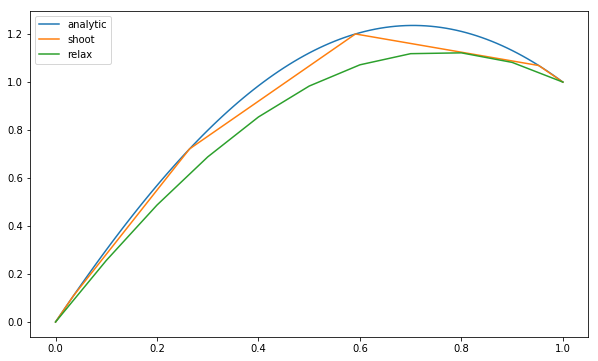

In [6]:
fig = plt.figure(1, figsize=(10,6))
xana = np.linspace(0,1,101)
uana = analytic(xana)
plt.plot(xana,uana, label="analytic")
plt.plot(bvpshoot.xvals, bvpshoot.uvals, label="shoot")
plt.plot(bvprelax.xvals, bvprelax.uvals, label="relax")
plt.legend()

## Animate solutions using pyWidgets and bqplot

- use matplotlib for publication figures
- use bqplot for nice interactive Jupyter plots
- use ipywidget for anything interactive in Jupyter (Buttons, slider, ...)

you might need tor run `jupyter nbextension enable --py widgetsnbextension` for jupyter notebook (see https://ipywidgets.readthedocs.io/en/latest/user_install.html) for classical Jupyter notebook
and in either case restart the notebook server (not just the kernel)

In [7]:
import numpy as np
import pandas as pd
import bqplot.pyplot as bplt
import ipywidgets as widgets
import time

### Create Plot

In [8]:
fig = bplt.figure(title="BVP solutions")
xana = np.linspace(0,1,101)
uana = analytic(xana)
ana  = bplt.scatter( xana, uana, label='analytic')
bplt.xlabel("x")
bplt.ylabel("u(x)")
bplt.ylim(0,2)
bplt.show()

### Create a Button

In [9]:
btn = widgets.Button(description="Start", icon="play")

In [10]:
N = 100
bvprelax = BVPRelax( simpleBVPFunc, xbounds, ubounds, N)
eps = 1e-6

In [11]:
figanim = bplt.figure(animation_duration=100, title="BVP solutions")
xana = np.linspace(0,1,101)
uana = analytic(xana)
ana  = bplt.scatter( xana, uana, label='analytic')
bplt.xlabel("x")
bplt.ylabel("u(x)")
bplt.ylim(0,2)

LinearScale(max=2.0, min=0.0)

### Callback to update figure

In [17]:
def update_figure(btn):
    while bvprelax.change() > eps:
        bvprelax.relax()
        with ana.hold_sync():
                ana.x = bvprelax.xplot[0]
                ana.y = bvprelax.uplot[0]
        time.sleep(1)

btn.on_click(update_figure)

In [ ]:
bvprelax.uplot[0]

In [18]:
## UI Combining Button & Chart
widgets.VBox([btn, figanim])

## Animate solutions

The relaxation method will only print every 1000th frame (!!!)

In [21]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

In [22]:
class AnimatedBVP(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, xplot, yplot):
        self.xplot=xplot
        self.yplot=yplot
        self.i = 0
        self.stream = self.data_stream()
        self.nframes = len(xplot)
        self.data = None
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        xana = np.linspace(0,1,101)
        uana = analytic(xana)
        self.ax.plot( xana, uana, label='analytic')
        plt.xlabel("x")
        plt.ylabel("u(x)")
        plt.ylim(0,2)
        self.fig.show()
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=1000,
                                           frames=self.nframes,
                                           init_func=self.setup_plot, blit=False)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        x,y = next(self.stream)
        self.myplot = self.ax.plot(x, y)
        
        return self.myplot,

    def data_stream(self):
        while True:
            yield self.xplot[self.i], self.yplot[self.i]


    def update(self, i):
        """Update the scatter plot."""
        self.i = i
        self.data = next(self.stream)        

        # Set x and y data...
        self.myplot = self.ax.plot( self.data[0], self.data[1], label="iteration "+str(self.i))
        self.ax.legend()

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.myplot,

KeyboardInterrupt: 

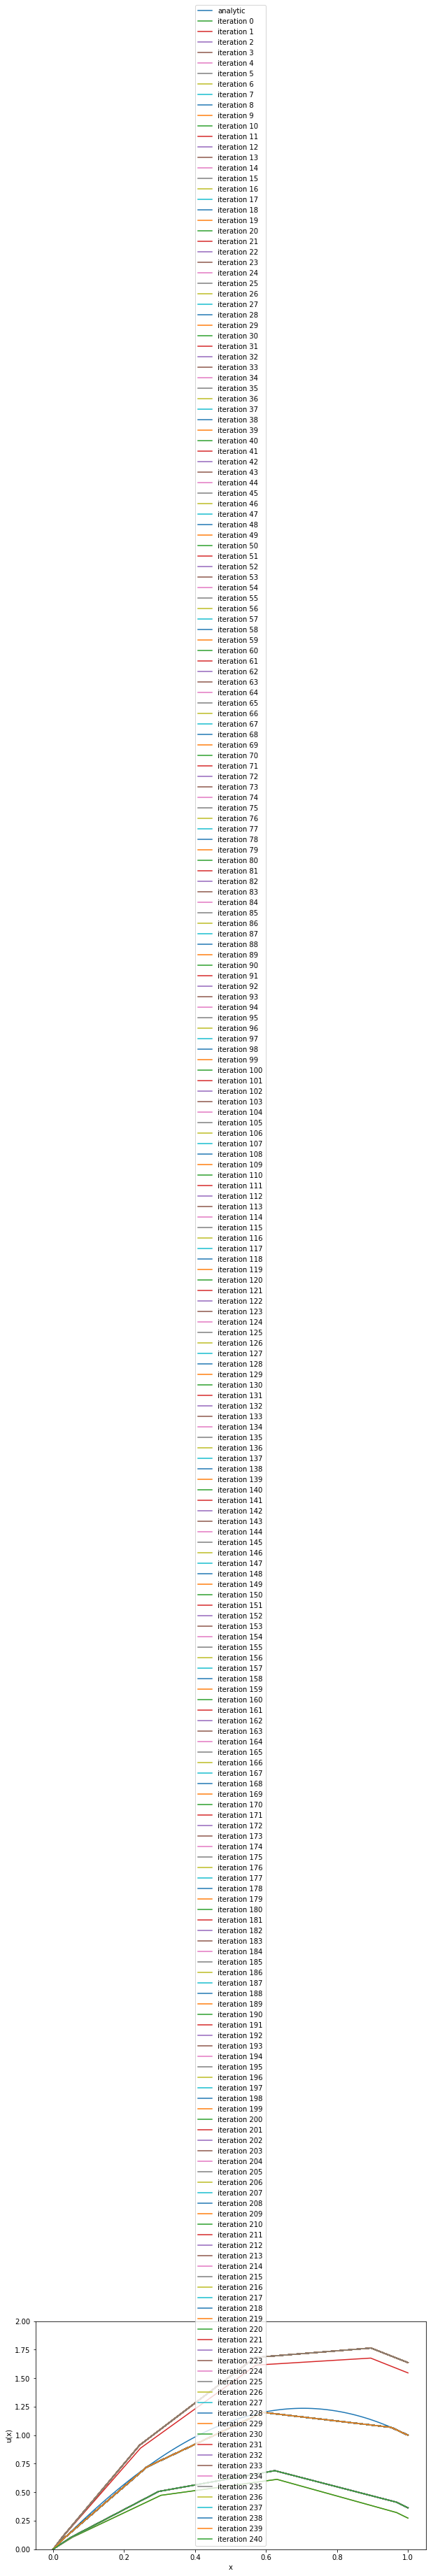

In [23]:
anim1 = AnimatedBVP(xplot=bvpshoot.xplot, yplot=bvpshoot.uplot)
HTML(anim1.ani.to_html5_video())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


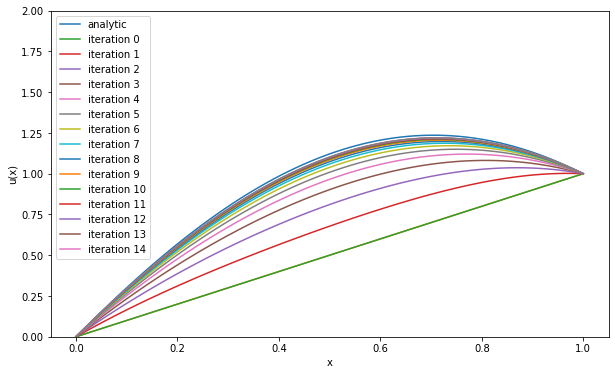

In [8]:
anim2 = AnimatedBVP(xplot=bvprelax.xplot[::1000], yplot=bvprelax.uplot[::1000])
HTML(anim2.ani.to_html5_video())